**General Additive Model**

---



**Fb-Prophet**

Instead of using correlation between values from similar time stamps, we can train our model on overall trends and add some seasonal effect to it. The principle behind GAM is similar to that of regression model. Unlike regression which uses individual predictor for outcome, GAM uses sum of smooth function to predict the outcome. The smooth functions here includes functions describing trend component, seasonal component, holiday component and so on. As GAM comprises of functions, we can isolate the individual function and evaluate its effect in prediction, which makes GAM more interpretable. An example of GAM is fbProphet.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

The data science team at Facebook found that by combining automatic forecasting with analyst-in-the-loop forecasts for special cases, it is possible to cover a wide variety of business use-cases. The following diagram illustrates the forecasting process used in prophet:
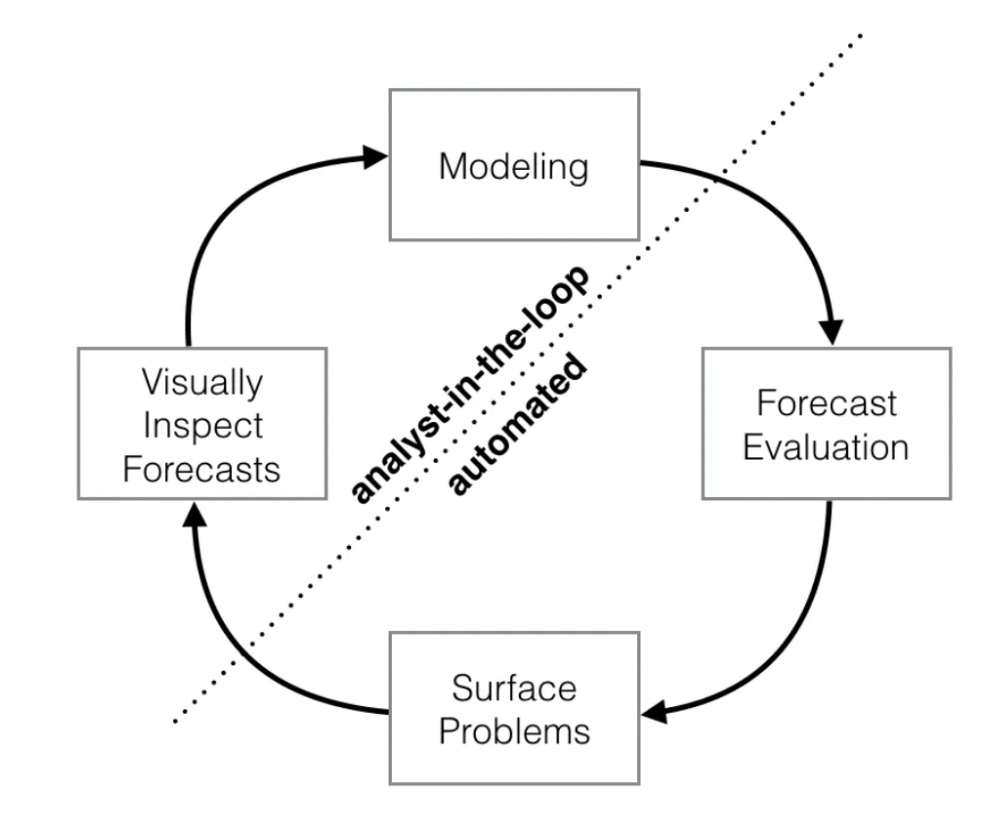

Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t) = g(t) + s(t) + h(t) + e(t)

Here,

g(t) is a trend function which models the non-periodic changes. It can be either a linear function or a logistic function.

s(t) represents a periodic changes i.e weekly, monthly, yearly. An yearly seasonal component is modeled using Fourier series and weekly seasonal component using dummy variables.

h(t) is a function that represents the effect of holidays which occur on irregular schedules.(n≥1 days)

The term e(t) represents error changes that are not accommodated by the model.

In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet

In [4]:
#import libraries
import pandas as pd
from prophet import Prophet
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame, concat
from sklearn.metrics import mean_absolute_error
from numpy import asarray
from pandas import read_csv
import random
import time
from sklearn.metrics import accuracy_score

In [ ]:
hr_data = pd.read_csv("HR_interpolated_data.csv")
hr_data.head()

In [ ]:
hr_data.shape

(5995837, 4)

In [ ]:
resp_data = pd.read_csv("RespRate_interpolated_data.csv")
resp_data.head()

In [ ]:
resp_data.shape

(1006647, 4)

In [ ]:
survival_data = read_csv('combined_data_with_survival.csv')

In [ ]:
survival_data

In [ ]:
survival_data.shape

(771666, 5)

Check for the presence of null values

In [ ]:
hr_nulls = hr_data.isnull().sum()
resp_nulls = resp_data.isnull().sum()

In [ ]:
survival_nulls = survival_data.isnull().sum()

In [ ]:
hr_nulls

PatientID    0
Timestamp    0
Metric       0
Value        0
dtype: int64

In [ ]:
resp_nulls

PatientID    0
Timestamp    0
Metric       0
Value        0
dtype: int64

In [ ]:
survival_nulls

PatientID            0
Timestamp            0
HR                   0
RespRate             0
In-hospital_death    0
dtype: int64

Visualize prevalent trends

In [ ]:
common_patients = np.intersect1d(hr_data['PatientID'].unique(), resp_data['PatientID'].unique())

np.random.seed(0)
selected_patients = np.random.choice(common_patients, 5, replace=False)

In [ ]:
def plot_patient_data(patient_id, hr_data, resp_data, metric):
    plt.figure(figsize=(12, 6))
    patient_hr_data = hr_data[hr_data['PatientID'] == patient_id]
    patient_resp_data = resp_data[resp_data['PatientID'] == patient_id]

    if metric == 'HR':
        plt.plot(patient_hr_data['Timestamp'], patient_hr_data['Value'], label='Heart Rate')
        plt.title(f"Heart Rate Trend for Patient {patient_id}")
    elif metric == 'RespRate':
        plt.plot(patient_resp_data['Timestamp'], patient_resp_data['Value'], label='Respiration Rate')
        plt.title(f"Respiration Rate Trend for Patient {patient_id}")

    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for patient_id in selected_patients:
    plot_patient_data(patient_id, hr_data, resp_data, 'HR')
    plot_patient_data(patient_id, resp_data, hr_data, 'RespRate')

Run Prophet on each of the two dataframes

In [ ]:
unique_patients = list(survival_data['PatientID'].unique())

In [ ]:
len(unique_patients)

266

In [ ]:
print(survival_data.groupby('PatientID').size().reset_index(name='NumDatapoints'))

     PatientID  NumDatapoints
0       132543           2901
1       132554           2901
2       132577           2901
3       132597           2901
4       132703           2901
..         ...            ...
261     142500           2901
262     142573           2901
263     142580           2901
264     142621           2901
265     142654           2901

[266 rows x 2 columns]


In [ ]:
survival_data['Timestamp'] = survival_data.groupby('PatientID')['Timestamp'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 2900 + 1)

In [ ]:
survival_data

,PatientID,Timestamp,HR,RespRate,In-hospital_death
0,132543,1.0,74.0,17.0,0
1,132543,2.0,74.0,17.0,0
2,132543,3.0,74.0,17.0,0
3,132543,4.0,74.0,17.0,0
4,132543,5.0,74.0,17.0,0
...,...,...,...,...,...
771661,142654,2897.0,63.0,16.0,0
771662,142654,2898.0,63.0,16.0,0
771663,142654,2899.0,63.0,16.0,0
771664,142654,2900.0,63.0,16.0,0


In [ ]:
values = survival_data.groupby('PatientID')['HR'].apply(list).apply(list).tolist()

In [ ]:
pyplot.title("Heart Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Heart Rate")
pyplot.plot(values[0])
pyplot.show()

In [ ]:
def series_to_supervised(df, patient_id, n_in=1, n_out=1, dropnan=True):
    # Filter data for the specified patient ID
    patient_data = df[df['PatientID'] == patient_id][['PatientID', 'Timestamp', 'HR']].copy()

    # Prepare the DataFrame for Prophet with 'ds' and 'y' columns
    supervised_df = pd.DataFrame()
    supervised_df['ds'] = patient_data['Timestamp']
    supervised_df['y'] = patient_data['HR']

    if dropnan:
        supervised_df.dropna(inplace=True)

    print("Patient Data:")
    print(patient_data.head())

    return supervised_df


In [ ]:
def series_to_supervised_RespRate(df, patient_id, n_in=1, n_out=1, dropnan=True):
    # Filter data for the specified patient ID
    patient_data = df[df['PatientID'] == patient_id][['PatientID', 'Timestamp', 'RespRate']].copy()

    # Prepare the DataFrame for Prophet with 'ds' and 'y' columns
    supervised_df = pd.DataFrame()
    supervised_df['ds'] = patient_data['Timestamp']
    supervised_df['y'] = patient_data['RespRate']

    if dropnan:
        supervised_df.dropna(inplace=True)

    print("Patient Data:")
    print(patient_data.head())

    return supervised_df


In [ ]:
def train_test_split(data, n_test):
    return data.iloc[:-n_test], data.iloc[-n_test:]

In [ ]:
def prophet_forecast(train, testX):
    model = Prophet()
    model.fit(train)
    future = pd.DataFrame({'ds': testX['ds']})
    forecast = model.predict(future)
    yhat = forecast['yhat'].values
    return yhat

In [ ]:
def walk_forward_validation(data, n_test):
    predictions = []
    train, test = train_test_split(data, n_test)
    history = train.copy()

    for i in range(len(test)):
        testX = test.iloc[[i]]
        yhat = prophet_forecast(history, testX)
        predictions.append(yhat[0])
        history = history.append(testX)

    error = mean_absolute_error(test['y'].values, predictions)
    return error, test['y'].values, predictions

Running Prophet on all the patients

In [ ]:
random.seed(80)
random_patients = [random.randint(0, len(unique_patients)) for _ in range(266)]

In [ ]:
patient_ids = [(unique_patients[index]) for index in random_patients]

In [ ]:
hr_total_error=[]
hr_all_predictions=[]
accuracy_hr = []

In [ ]:
start_time = time.perf_counter()
for patient_id in patient_ids:
    # Transform the time series data into supervised learning
    data = series_to_supervised(survival_data, patient_id, n_in=100, n_out=100)
    print(f"Data for Patient ID {patient_id}:")
    print(data.head())

    # Perform walk-forward validation and get predictions
    error, testy, predictions = walk_forward_validation(data, 100)
    hr_all_predictions.append(predictions)
    hr_total_error.append(error)

    print(f"MAE for Patient ID {patient_id}: {error}")
    print(f"Test vs Predictions for Patient ID {patient_id}:", list(zip(testy, predictions)))
    accuracy_hr.append(accuracy_score(testy, predictions))
end_time = time.perf_counter()

In [ ]:
print("Average mean average error across all patients = ", sum(hr_total_error)/len(hr_total_error))

Average mean average error across all patients =  2.373946933335376


In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
accuracy = sum(accuracy_hr)/len(accuracy_hr))
accuracy

In [ ]:
hr_all_predictions

In [ ]:
rounded_predictions = [[round(pred, 0) for pred in sublist] for sublist in hr_all_predictions]

In [ ]:
rounded_predictions = [[int(j) for j in i] for i in rounded_predictions]

In [ ]:
rounded_predictions

In [ ]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred >= 100 or pred <= 60 else None for pred in predictions]

    timesteps = np.arange(2802, 2902)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Heart Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Heart Rate')
    plt.legend()
    plt.show()

In [ ]:
for i in range(len(rounded_predictions)):
  plot_predictions(rounded_predictions[i])

In [ ]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['HR'])
  return values

In [ ]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 60 or above 100 in red
    threshold_low = 60
    threshold_high = 100
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
all_values=[]

In [ ]:
i=0
for pid in patient_ids:
  og=get_og_values(survival_data,pid)
  new_og=og[:2801]
  predictions=rounded_predictions[i]
  all_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
result_df = pd.DataFrame({'PatientID': [p for p, values in zip(patient_ids, all_values) for _ in range(len(values))],
                   'HR': [val for values in all_values for val in values]})

In [ ]:
result_df

In [ ]:
random.seed(75)
random_patients = [random.randint(0, len(unique_patients)) for _ in range(5)]
patient_ids = [(unique_patients[index]) for index in random_patients]
print(patient_ids)
print(random_patients)

hr_total_error_2=[]
hr_all_predictions_2=[]
accuracy_hr = []

start_time = time.perf_counter()
for patient_id in patient_ids:
    # Transform the time series data into supervised learning
    data = series_to_supervised(survival_data, patient_id, n_in=100, n_out=100)
    print(f"Data for Patient ID {patient_id}:")
    print(data.head())

    # Perform walk-forward validation and get predictions
    error, testy, predictions = walk_forward_validation(data, 100)
    hr_all_predictions_2.append(predictions)
    hr_total_error_2.append(error)

    print(f"MAE for Patient ID {patient_id}: {error}")
    print(f"Test vs Predictions for Patient ID {patient_id}:", list(zip(testy, predictions)))
    accuracy_hr.append(accuracy_score(testy, predictions))
end_time = time.perf_counter()


In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
accuracy = sum(accuracy_hr)/len(accuracy_hr))
accuracy

In [ ]:
print("Average mean average error across all patients = ", sum(hr_total_error_2)/len(hr_total_error_2))
rounded_predictions = [[round(pred, 0) for pred in sublist] for sublist in hr_all_predictions_2]
rounded_predictions = [[int(j) for j in i] for i in rounded_predictions]

for i in range(len(rounded_predictions)):
  plot_predictions(rounded_predictions[i])

all_values_2=[]

i=0
for pid in patient_ids:
  og=get_og_values(survival_data,pid)
  new_og=og[:2801]
  predictions=rounded_predictions[i]
  all_values_2.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
result_df_2 = pd.DataFrame({'PatientID': [p for p, values in zip(patient_ids, all_values_2) for _ in range(len(values))],
                   'HR': [val for values in all_values_2 for val in values]})

In [ ]:
result_df_2

Respiratory Rate

In [ ]:
rr_values = survival_data.groupby('PatientID')['RespRate'].apply(list).apply(list).tolist()

In [ ]:
# plot dataset
pyplot.title("Respiratory Rate vs Timestamp for Patient ID 132543")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Respiratory Rate")
pyplot.plot(rr_values[0])
pyplot.show()

In [ ]:
rr_total_error=[]
rr_all_predictions=[]
accuracy_rr = []

In [ ]:
start_time = time.perf_counter()
for patient_id in patient_ids:
    # Transform the time series data into supervised learning
    data = series_to_supervised_RespRate(survival_data, patient_id, n_in=100, n_out=100)
    print(f"Data for Patient ID {patient_id}:")
    print(data.head())

    # Perform walk-forward validation and get predictions
    error, testy, predictions = walk_forward_validation(data, 100)
    rr_all_predictions.append(predictions)
    rr_total_error.append(error)

    print(f"MAE for Patient ID {patient_id}: {error}")
    print(f"Test vs Predictions for Patient ID {patient_id}:", list(zip(testy, predictions)))
    accuracy_rr.append(accuracy_score(testy, predictions))
end_time = time.perf_counter()

In [ ]:
print("Average mean average error across all patients = ", sum(rr_total_error)/len(rr_total_error))

In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
accuracy = sum(accuracy_rr)/len(accuracy_rr))
accuracy

In [ ]:
rr_rounded_predictions = [[round(pred, 0) for pred in sublist] for sublist in rr_all_predictions]
rr_rounded_predictions = [[int(j) for j in i] for i in rounded_predictions]

In [ ]:
rr_rounded_predictions

In [ ]:
def plot_predictions(predictions):
    highlight_predictions = [pred if pred > 20 or pred < 12 else None for pred in predictions]

    timesteps = np.arange(2802, 2902)

    plt.plot(timesteps, predictions, label='Predictions', marker='o', linestyle='-', color='orange')
    plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

    plt.title('Respiratory Rate Prediction for 100 Timesteps')
    plt.xlabel('Timestep')
    plt.ylabel('Respiratory Rate')
    plt.legend()
    plt.show()

Plot future predictions for each patient and indicate abnormalities

In [ ]:
for i in range(len(rr_rounded_predictions)):
  plot_predictions(rr_rounded_predictions[i])

Plot all values for patients to assess continuation in trends

In [ ]:
def get_og_values(series,patientid):
  values = list(series[series['PatientID'] == patientid]['RespRate'])
  return values

In [ ]:
all_resp_values=[]

In [ ]:
i=0
for pid in patient_ids:
  og=get_og_values(survival_data,pid)
  new_og=og[:2801]
  predictions=rr_rounded_predictions[i]
  all_resp_values.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

In [ ]:
def plot_combined_values(og, predictions):
    timestamps = list(range(1, 2902))
    combined_df = pd.DataFrame({
        'Timestamp': timestamps,
        'Value': og+predictions
    })

    # Plot the values against Timestamp
    plt.plot(combined_df['Timestamp'][:2901], combined_df['Value'][:2901], marker='o', linestyle='-', color='blue', label='Original Values')

    # Highlight values below 12 or above 20 in red
    threshold_low = 12
    threshold_high = 20
    highlight_indices = np.where((combined_df['Value'] < threshold_low) | (combined_df['Value'] > threshold_high))[0]
    #plt.scatter(combined_df['Timestamp'].iloc[highlight_indices], combined_df['Value'].iloc[highlight_indices], color='red', label='Abnormal Rate',zorder=5)

    # Print predicted values in a different color (red)
    predicted_indices = range(len(og), len(og) + len(predictions))
    plt.scatter(combined_df['Timestamp'].iloc[predicted_indices], combined_df['Value'].iloc[predicted_indices], color='green', label='Predicted Values', zorder=3)

    plt.title('Original vs Predicted Values')
    plt.xlabel('Timestamp (seconds)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [ ]:
all_resp = [val for values in all_resp_values for val in values]
result_df['RespRate'] = all_resp

In [ ]:
rr_total_error_2=[]
rr_all_predictions_2=[]
accuracy_rr = []

start_time = time.perf_counter()
for patient_id in patient_ids:
    # Transform the time series data into supervised learning
    data = series_to_supervised_RespRate(survival_data, patient_id, n_in=100, n_out=100)
    print(f"Data for Patient ID {patient_id}:")
    print(data.head())

    # Perform walk-forward validation and get predictions
    error, testy, predictions = walk_forward_validation(data, 100)
    rr_all_predictions_2.append(predictions)
    rr_total_error_2.append(error)

    print(f"MAE for Patient ID {patient_id}: {error}")
    print(f"Test vs Predictions for Patient ID {patient_id}:", list(zip(testy, predictions)))
    accuracy_rr.append(accuracy_score(testy, predictions))

end_time = time.perf_counter()

print("Average mean average error across all patients = ", sum(rr_total_error_2)/len(rr_total_error_2))
accuracy = sum(accuracy_rr)/len(accuracy_rr))
print(accuracy)
rr_rounded_predictions_2 = [[round(pred, 0) for pred in sublist] for sublist in rr_all_predictions_2]
rr_rounded_predictions_2 = [[int(j) for j in i] for i in rr_rounded_predictions_2]

for i in range(len(rr_rounded_predictions_2)):
  plot_predictions(rr_rounded_predictions_2[i])

all_resp_values_2=[]

i=0
for pid in patient_ids:
  og=get_og_values(survival_data,pid)
  new_og=og[:2801]
  predictions=rr_rounded_predictions_2[i]
  all_resp_values_2.append(new_og+predictions)
  print("Plotting for patient ID:", pid)
  plot_combined_values(new_og,list(predictions))
  i+=1

all_resp_2 = [val for values in all_resp_values_2 for val in values]
result_df_2['RespRate'] = all_resp_2


In [ ]:
time_taken = end_time - start_time
time_taken

In [ ]:
result_df_2

In [ ]:
df_2=result_df_2.copy()

In [ ]:
df_2['Timestamp'] = df_2.groupby('PatientID').cumcount() + 1

In [ ]:
df_2

In [ ]:
df_2.to_csv('prophet_results_final.csv', index=False)

In [ ]:
dff=pd.read_csv("prophet_results_final.csv")

In [ ]:
dff

In [ ]:
dff = dff.groupby('PatientID').tail(100)

In [ ]:
dff.tail()

In [ ]:
result_df.to_csv('prophet_results.csv', index=False)

In [ ]:
df=result_df.copy()

In [ ]:
df['Timestamp'] = df.groupby('PatientID').cumcount() + 1

In [ ]:
df

In [ ]:
df.to_csv('prophet_results.csv', index=False)

In [ ]:
df=pd.read_csv("prophet_results.csv")

In [ ]:
df

In [ ]:
df['Timestamp'] = df.groupby('PatientID').cumcount() + 1

In [ ]:
df

In [ ]:
df['RespRate'] = df['RespRate'].round()

<ipython-input-7-8c6444ca01fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RespRate'] = df['RespRate'].round()


In [ ]:
df['HR'] = df['HR'].round()

<ipython-input-8-292f71a65271>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HR'] = df['HR'].round()


In [ ]:
df

In [ ]:
df = df.groupby('PatientID').tail(100)

In [ ]:
df.tail()

In [ ]:
df

In [ ]:
set(df['PatientID'].tolist())

In [ ]:
patient_hr_list = df[df['PatientID'] == 141624]['HR'].tolist()

In [ ]:
patient_rr_list = df[df['PatientID'] == 141624]['RespRate'].tolist()

In [ ]:
patient_hr_list

In [ ]:
patient_rr_list

In [ ]:
timestamp = df[df['PatientID'] == 141624]['Timestamp'].tolist()

In [ ]:
# Separate values above 100 and below 60
highlighted_values = [value if value >= 100 or value <= 60 else None for value in patient_hr_list]

# Plot the original heart rate values
plt.plot(timestamp, patient_hr_list, marker='o', linestyle='-', label='Original Heart Rate',color='orange')

# Highlight values above 100 and below 60 in a separate plot
plt.scatter(timestamp, highlighted_values, color='red', label='Highlighted Values',zorder=5)

# Add labels and legend
plt.title('Predicted Heart Rate Values for 100 Timesteps')
plt.xlabel('Timestamp')
plt.ylabel('Heart Rate')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Separate values above 20 and below 12
highlighted_values = [value if value >= 20 or value <= 12 else None for value in patient_rr_list]

# Plot the original heart rate values
plt.plot(timestamp, patient_rr_list, marker='o', linestyle='-', label='Original Respiratory Rate',color='orange')

# Highlight values above 20 and below 12 in a separate plot
plt.scatter(timestamp, highlighted_values, color='red', label='Highlighted Values',zorder=5)

# Add labels and legend
plt.title('Predicted Respiratory Rate Values for 100 Timesteps')
plt.xlabel('Timestamp')
plt.ylabel('Respiratory Rate')
plt.legend()

# Show the plot
plt.show()

In [ ]:
df.tail()

In [ ]:
df.to_csv('prophet_results_2.csv', index=False)

In [ ]:
# Placeholder for storing MAE values for different 'n_in' settings
n_in_values = [60, 80, 100, 120, 140, 160, 180, 200]
mae_values = []

for n_in in n_in_values:
    # Assuming you are using a single patient ID for this example
    patient_id = patient_ids[0]

    # Transform the time series data into supervised learning
    data = series_to_supervised(survival_data, patient_id, n_in=n_in, n_out=100)

    # Perform walk-forward validation and get predictions
    error, testy, predictions = walk_forward_validation(data, 100)

    # Store the MAE for the current 'n_in' value
    mae_values.append(error)

# Now, plot the MAE values against the 'n_in' values
plt.figure(figsize=(10, 6))
plt.plot(n_in_values, mae_values, marker='o')
plt.title('n_in vs MAE')
plt.xlabel('n_in')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

In [ ]:
df_prophet = pd.read_csv('prophet_results_final.csv')
df_xgboost = pd.read_csv('xgboost_results.csv')
df_arima = pd.read_csv('arima_results.csv')

df_merged = df_xgboost.merge(df_prophet, on=['PatientID', 'Timestamp'], suffixes=('_xgboost', '_prophet'))
df_merged = df_merged.merge(df_arima, on=['PatientID', 'Timestamp'])

df_merged['HR'] = 0.5 * df_merged['HR_xgboost'] + 0.25 * df_merged['HR_prophet'] + 0.25 * df_merged['HR']
df_merged['RespRate'] = 0.5 * df_merged['RespRate_xgboost'] + 0.25 * df_merged['RespRate_prophet'] + 0.25 * df_merged['RespRate']

final_df = df_merged[['PatientID', 'HR', 'RespRate', 'Timestamp']]

print(final_df)

In [23]:
final_df.to_csv('final_results.csv', index=False)


In [1]:
file_names = ['ARIMA_133696.csv', 'ARIMA_138022.csv', 'ARIMA_139739.csv', 'ARIMA_139791.csv', 'ARIMA_140414.csv',
              'ARIMA_141015.csv', 'ARIMA_141428.csv', 'ARIMA_141560.csv', 'ARIMA_141624.csv', 'ARIMA_142580.csv']


In [13]:
dataframes = []

In [14]:
for file in file_names:
    df = pd.read_csv(file)
    df.drop(['Unnamed: 0', 'Timestamp'], axis=1, inplace=True)
    dataframes.append(df)

In [ ]:
dataframes

In [16]:
final_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
final_df

In [19]:
final_df['Timestamp'] = final_df.groupby('PatientID').cumcount() + 1

In [ ]:
final_df

In [21]:
final_df.to_csv('arima_results.csv', index=False)